# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.io
from scipy.special import expit
from math import *
from scipy import optimize
from sklearn import svm

In [2]:
sns.set_style('whitegrid')
%matplotlib inline

# Functions

In [158]:
sigma = 2

# Check Model ( return coef for verified model ) 
def checkModel(model):
    # Initializing the coef
    coef = None
    # Checking Model existence
    if( model is not None ):
        if( model.kernel == 'linear' ):
            if( len(model.coef_.shape) >= 2 ):
                coef = model.coef_[0]
            else:
                coef = model.coef_
        else:
            coef = None
    else:
        
        # Model has some problems
        return { status: False, msg: 'Model has problem', "coef": None }
    
    return { "status": True, "msg": 'Model is correct', "coef": coef}

# Traing SVM
def visualizeBoundry(X, y, model= None):
    # Initializing the coef
    coef = None

    # Checking Model existence
    checkedModel = checkModel(model)
    
    if(checkedModel["status"]):
        coef = checkedModel["coef"]
        
        # Setting range of the X,y
        X_range = np.linspace(min( X.T[1] ) , max( X.T[1] ), 100 )
        y_range = -1 * ( coef[1] * X_range + model.intercept_ ) / coef[2]

        # Converting X_range && y_range to Dataframe
        df = pd.DataFrame( [X_range, y_range] ).T
        df.columns = ['first', 'second']

        # Plotting data
        sns.plt.plot('first', 'second', data= df)
        
    else:
        return checkedModel["msg"]
    
def plotData(X,y):
    pos = ( y == 1 );
    neg = ( y == 0 );
    
    plt.scatter(X[pos].T[0], X[pos].T[1], c='k', marker='+')
    plt.scatter(X[neg].T[0], X[neg].T[1], c='y', marker='o')
    
def visualizeBoundryCountor(X, y, model= None):
    # Initializing the coef
    coef = None

    # Checking Model existence
    checkedModel = checkModel(model)
    
    if(checkedModel["status"]):

        # Setting range of the x,y
        X_range = np.linspace(min( X.T[0] ), max( X.T[0] ), 400)
        y_range = np.linspace(min( X.T[1] ), max( X.T[1] ), 400)
        
        # Creating Z matrix for holding predections
        z = np.zeros( (len(X_range), len(y_range) ) )
        X_meshed, y_meshed = np.meshgrid(X_range, y_range)
        
        z = model.predict(np.c_[ X_meshed.ravel(), y_meshed.ravel() ])
        z = z.reshape( X_meshed.shape )       
        
        plt.figure(figsize=(12,8))
        plt.contourf(X_meshed, y_meshed, z, alpha= 0.2)
        plotData(X,y)
        
        plt.show()
    else:
        return checkedModel["msg"]
    
def gaussianKernel(x1, x2):
    dist = ( x1 - x2 ).T.dot(x1 - x2)
    return np.exp( ( -1 * ( dist ) ) / (2 * ( sigma ** 2 )))

def findBestModel(X,y, Xval, yval):
    # Initializing the Possible values for both C and Sigma
    pValues = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]);
    
    # Creating matrix for holding the error of each model
    error = np.zeros((len(pValues) ** 2,1))
    
    # Computing model error for each permutation of the sigma and C
    for i in range(len(pValues)):
        for j in range(len(pValues)):
            # Initializing The Model
            model = svm.SVC(C=pValues[i] ,kernel= 'rbf' ,gamma= 2 * ( pValues[j] ** 2 ))
            
            # Fitting Data to The Model
            model.fit(X,y)
            
            # Computing error of the Model on the Cross Validation Dataset
            error[ i * len(pValues) + j ] = 1 - model.score(Xval, yval)
    
    # Getting the minimum value index in error matrix
    idx = np.argmin(error)
    
    # Finding C, sigma for model with minimum error
    i = np.floor(idx / len(pValues))
    j = idx - i * len(pValues)
    
    C = pValues[int(i)]
    sigma = pValues[int(j)]
    
    return { "C": C,
           "sigma": sigma }

# SVM - Linear Kernel

## Load The Dataset 1

In [4]:
mat = scipy.io.loadmat('ex6data1.mat');
X = mat['X']   # Transpose for better accesing to columns
y = mat['y'].T[0]    # Transpose for better accesing to columns

In [5]:
X_bias = np.insert(X,0,1,axis=1)

In [6]:
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

In [7]:
df = pd.concat([X_df, y_df],axis=1)
df.columns = ['first', 'second', 'out']

## Plot the Data

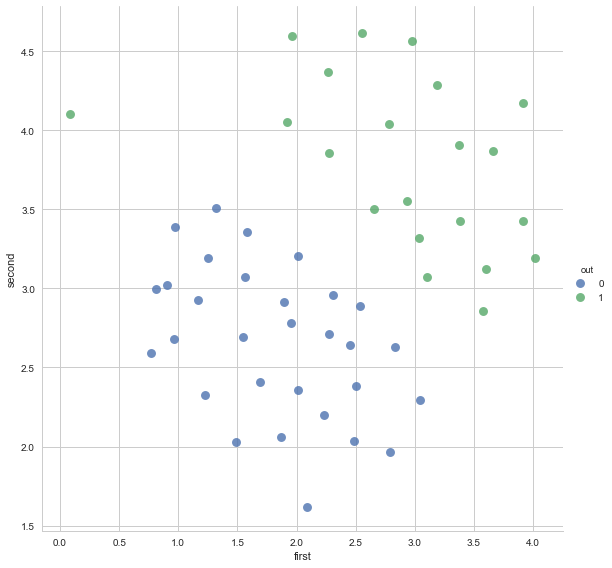

In [8]:
sns.lmplot(x="first",y= "second",data=df, hue="out", fit_reg=False, size= 8, scatter_kws={'s':80})

## Model Computing

In [9]:
clf = svm.SVC(C=100, kernel="linear", tol=1e-3)
clf.fit(X_bias, y)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

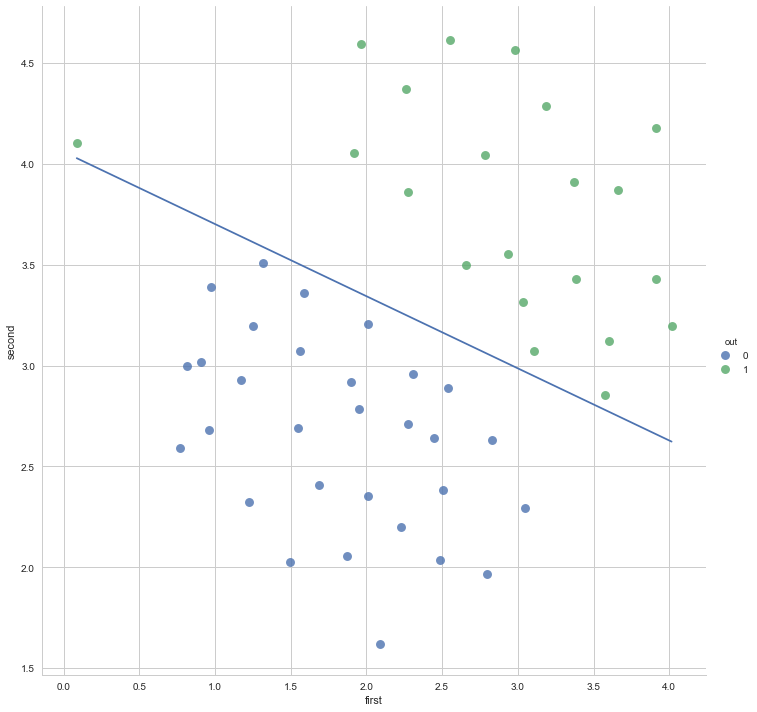

In [10]:
sns.lmplot('first', 'second', data=df, hue='out', fit_reg=False, size= 10, scatter_kws= { 's' : 80})
visualizeBoundry(X_bias, y, clf)

# SVM - Non-Linear Kernel

## Load the Dataset 2

In [80]:
mat = scipy.io.loadmat("ex6data2.mat")
X = mat['X']
y = mat['y'].T[0]

In [81]:
X_bias = np.insert(X,0,1,axis=1)

In [82]:
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

In [83]:
df = pd.concat([X_df, y_df],axis=1)
df.columns = ['first', 'second', 'out']

## Plot the Data

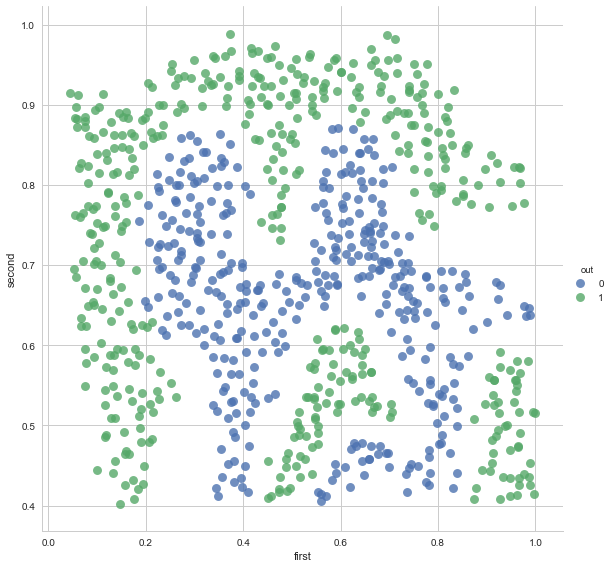

In [84]:
sns.lmplot("first", "second", data=df, hue="out", fit_reg=False, size= 8, scatter_kws={'s':80})

## Train The Model

In [85]:
sigma = 3
gamma = 2 * ( sigma ** 2 )
clf = svm.SVC(C=10, kernel='rbf', gamma=gamma)
clf.fit(X, y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=18, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

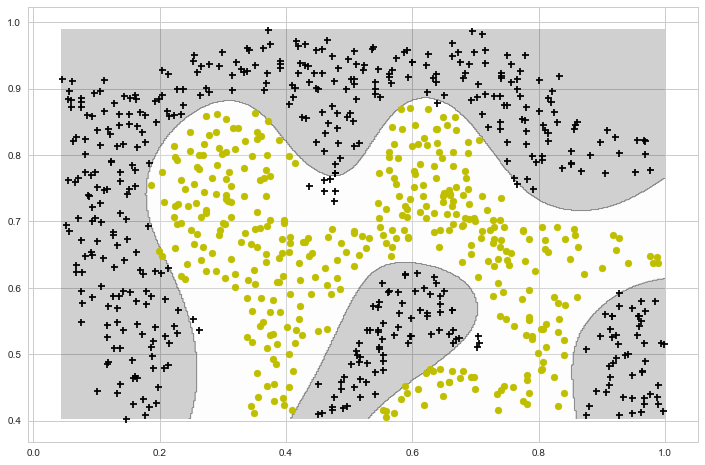

In [86]:
visualizeBoundryCountor(X, y, clf)

## Computing Model Error

In [90]:
clf.score(X, y)

0.98030127462340677

# SVM - Non-Linear Kernel

## Load The Dataset 3

In [167]:
mat = scipy.io.loadmat('ex6data3.mat')
X = mat["X"]
Xval = mat["Xval"]
y = mat["y"].T[0]
yval = mat["yval"].T[0]

In [168]:
X_bias = np.insert(X,0,1,axis=1)
Xval_bias = np.insert(Xval,0,1,axis=1)

In [169]:
X_df = pd.DataFrame(X)
Xval_df = pd.DataFrame(Xval)

y_df = pd.DataFrame(y)
yval_df = pd.DataFrame(yval)

In [170]:
df = pd.concat([X_df, y_df],axis=1)
df.columns = ['first', 'second', 'out']

In [171]:
dfval = pd.concat([Xval_df, yval_df],axis=1)
dfval.columns = ['first', 'second', 'out']

## Plot The Data

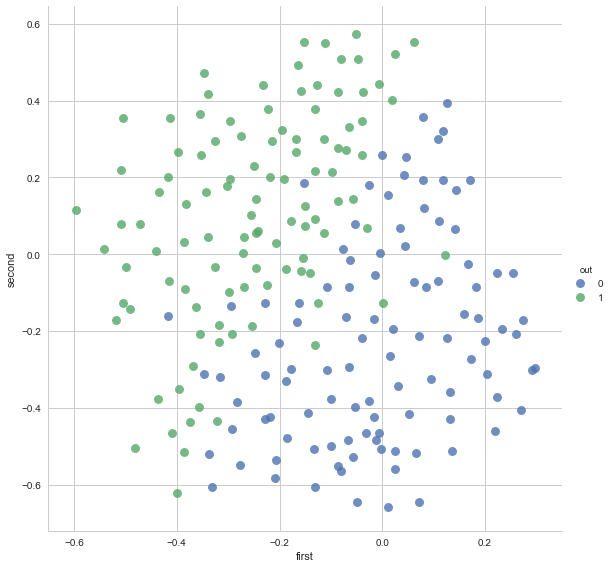

In [172]:
sns.lmplot("first", "second", data=df, hue="out", fit_reg=False, size= 8, scatter_kws={'s':80})

## Train The Model

In [173]:
findBestModel(X, y, Xval, yval)

{'C': 10.0, 'sigma': 3.0}

In [187]:
clf = svm.SVC(C=10, gamma= 2 * ( 3 ** 2 ), kernel='rbf')
clf.fit(X,y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=18, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

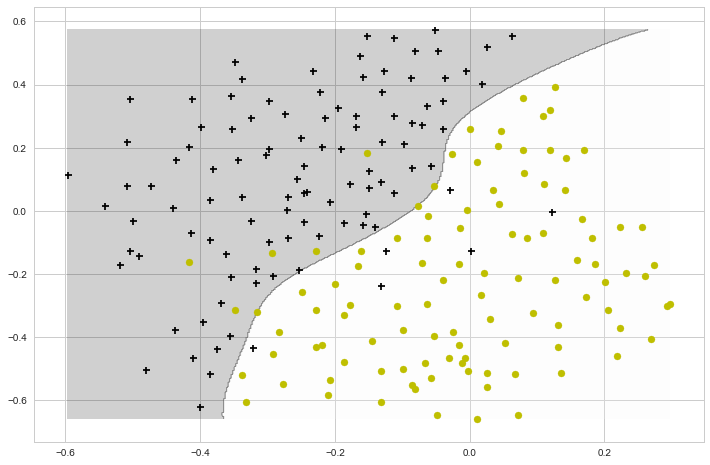

In [188]:
visualizeBoundryCountor(X,y, clf)

## Computing Model Error

In [189]:
clf.score(Xval,yval)

0.96499999999999997